# Flow Network Solver

### General imports

In [1]:
# %pylab
# %run FastFlowNets.py 64 1 0
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys, os
args = sys.argv
sys.executable

import numpy as np
import copy
from numpy import zeros as zeros
from numpy import ones as ones
from numpy import array as array
from numpy import arange as arange
from numpy import meshgrid as meshgrid
from numpy import dot as dot
from numpy.linalg import inv as inv

import numpy.linalg as la
import numpy.random as rand
import pickle
import networkx as nx
import matplotlib.pyplot as plt

# My functions
import NETfuncs, Constraints, Matrixfuncs, Solve

# figures
plt.rcParams['figure.figsize'] = (10,10)

In [2]:
# pip install networkx

### Roie Larger Network

In [3]:
## Prelims - sizes etc.

NGrid = 7  # lattice dimansion is Ngrid X Ngrid 
Periodic = False  # flag for lattice periodicity
typ = 'Cells'

a = NGrid
b = NGrid
ys = arange(b) - b//2 + 0.5
xs = arange(a) - a//2 + 0.5
xs = -xs
Y, X = meshgrid(xs, ys)
Pos = np.c_[X.flatten(), Y.flatten()]

In [4]:
## Build Incidence Matrices and vectors of edges

EI, EJ, EIEJ_plots, DM, NE, NN = Matrixfuncs.build_incidence(NGrid, NGrid, typ, Periodic)        

In [5]:
## Initiate K matrix

K, K_mat = Matrixfuncs.initiateK(NE)

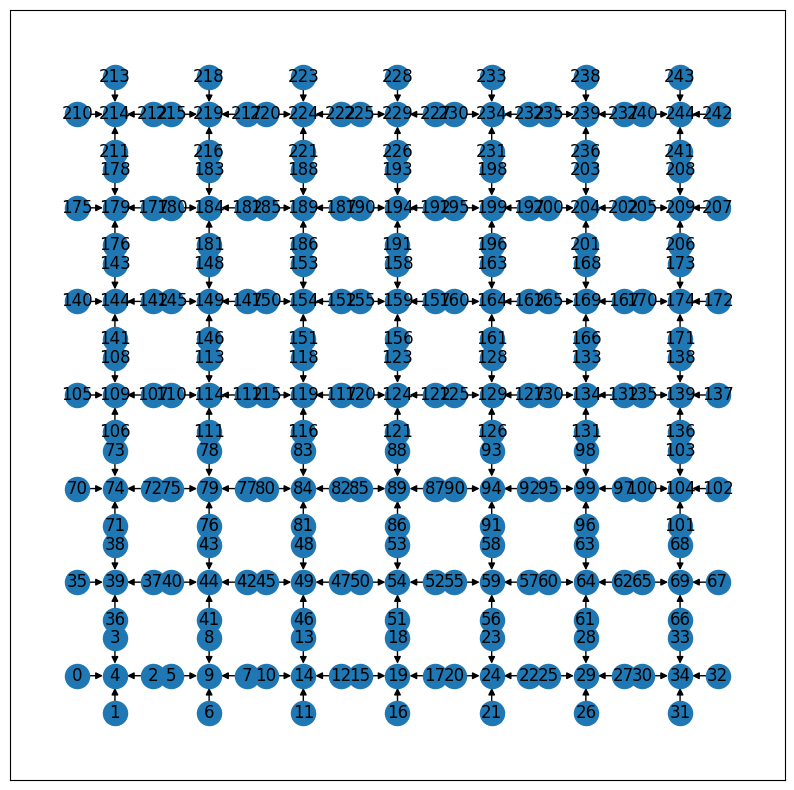

NET is ready


In [6]:
# build network and plot structure

NET = NETfuncs.buildNetwork(EIEJ_plots)

pos_lattice = NETfuncs.plotNetStructure(NET, 'Cells')
# print(pos_lattice)
# NETfuncs.plotNetStructure(NET, 'spectral')
# NETfuncs.plotNetStructure(NET, 'planar')

In [7]:
## Identify edges at connections of cells and at boundaries for ease of use

NConncetions = int(NGrid*(NGrid-1)*2)
EdgesConnections = [int(i) for i in range(NE-NConncetions, NE)]

NBoundaries = NGrid*4
left_side = [0 + 4*NGrid*i for i in range(NGrid)]
bottom_side = [1 + 4*i for i in range(NGrid)]
right_side = [2 + 4*(NGrid-1) + 4*NGrid*i for i in range(NGrid)]
top_side = [4*NGrid*(NGrid-1) + 3 + 4*i for i in range(NGrid)]
EdgesBounaries = np.append(left_side, np.append(bottom_side, np.append(right_side, top_side)))
# EdgesBounaries = np.array([], int)
EdgesTotal = np.append(EdgesConnections, EdgesBounaries)

In [8]:
## Set up constraints for whole loop

NConncetions = int(NGrid*(NGrid-1)*2)

NodeData_full = array([[1], [1]])  # input p value
# Nodes_full = array([[6], [35]])  # input p node
Nodes_full = array([[184], [44]])  # input p node


GroundNodes_full = array([[204], [64]])  # nodes with zero pressure
GroundNodes_full_Allostery = array([GroundNodes_full[i][0] for i in range(len(GroundNodes_full))])

EdgeData_full = array([[0], [0]])  # pressure drop value on edge

# Edges_full = array([EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[0])[0][0]) &  (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])], 
#                     EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[1])[0][0]) &  (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])]])

# Edges_full_Allostery = array([EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[0])[0][0]) &  (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])], 
#                               EdgesTotal[(EdgesTotal!=np.where(EI==Nodes_full[1])[0][0]) &  (EdgesTotal!=np.where(EI==GroundNodes_full[0])[0][0]) & (EdgesTotal!=np.where(EI==GroundNodes_full[1])[0][0])]])

Edges_full = array([EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[0])[0][0]) 
                               &  (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
                               & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])], 
                    EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[1])[0][0]) 
                               &  (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
                               & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])]])

Edges_full_Allostery = array([EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[0])[0][0]) 
                                         &  (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
                                         & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])], 
                              EdgesTotal[(EdgesTotal!=np.where(EJ==Nodes_full[1])[0][0]) 
                                         &  (EdgesTotal!=np.where(EJ==GroundNodes_full[0])[0][0]) 
                                         & (EdgesTotal!=np.where(EJ==GroundNodes_full[1])[0][0])]])


# Edges_full = array([EdgesConnections, EdgesConnections])
# output_edges = [np.where(np.append(EI, EJ)==GroundNodes_full[i])[0][0] % len(EI) for i in range(len(GroundNodes_full))]
output_edges = np.array([np.where(np.append(EI, EJ)==GroundNodes_full[i])[0] % len(EI) for i in range(len(GroundNodes_full))])
for i in range(len(GroundNodes_full)):
    print(np.where(np.append(EI, EJ)==GroundNodes_full[i])[0])
print(output_edges)

[440 441 442 443]
[328 329 330 331]
[[160 161 162 163]
 [ 48  49  50  51]]


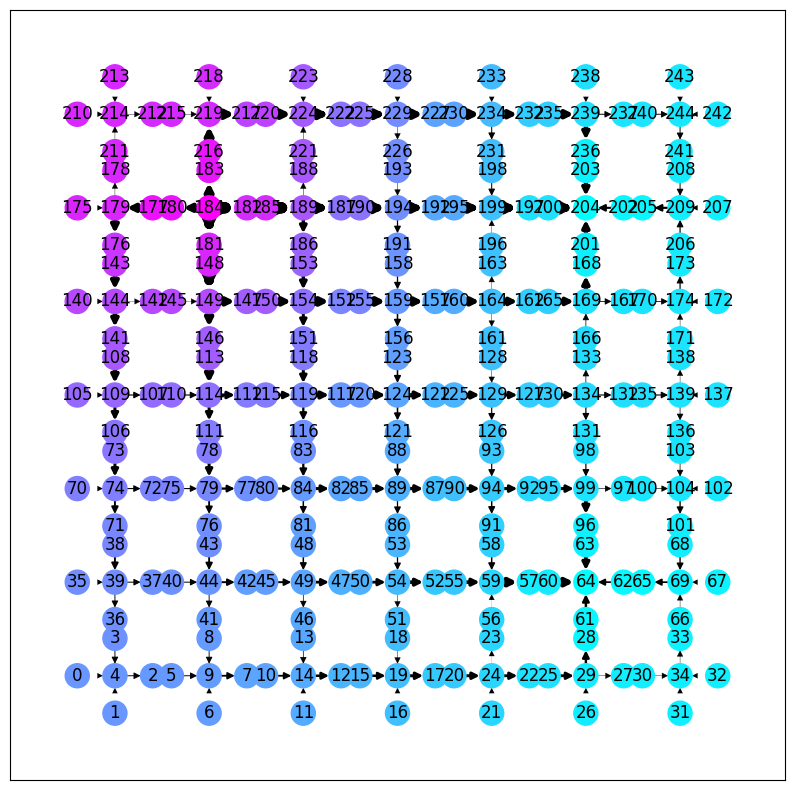

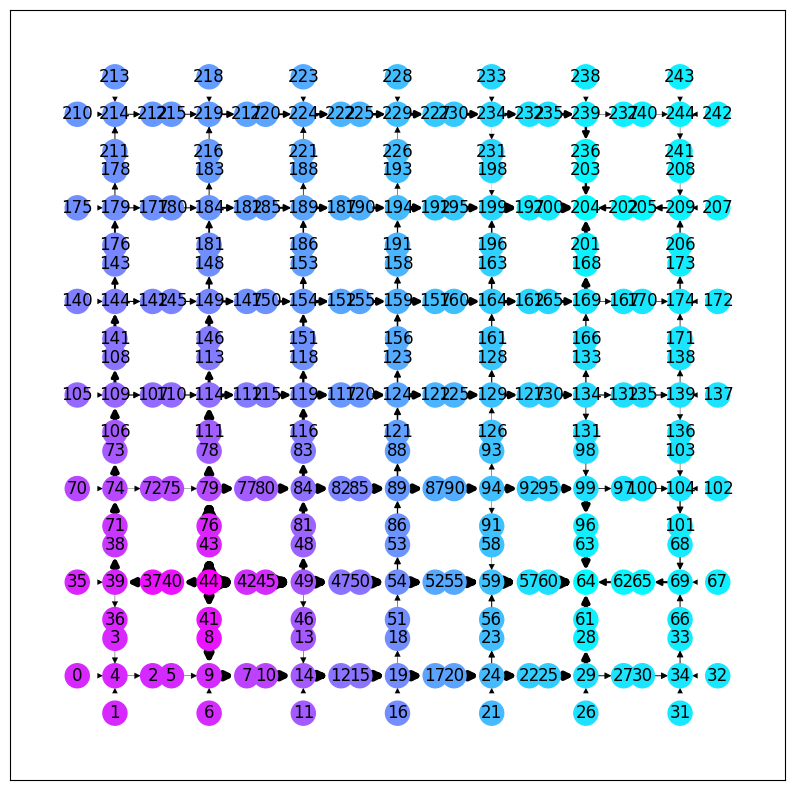

In [9]:
## Solve flow with no marbles, i.e. uniform high conductance, for normalization of flow

u_final_noCond = zeros([2, 2])

for i in range(2):
    NodeData = NodeData_full[i] 
    Nodes = Nodes_full[i] 
    EdgeData = EdgeData_full[i]
    Edges = Edges_full[i]
    GroundNodes = array([GroundNodes_full[0][0], GroundNodes_full[1][0]])
    
    Cstr_full, Cstr, f = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  # As matrix

    L, L_bar = Matrixfuncs.buildL(DM, K_mat, Cstr, NN)

    p, u = Solve.Solve_flow(L_bar, EI, EJ, K, f)
    
    # correct for very low velocities
    u[abs(u)<10**-10] = 0

    NETfuncs.PlotNetwork(p, u, K, NET, pos_lattice, EIEJ_plots, NN, NE) 
        
    # u_final_noCond[i,:] = u[output_edges]
    u_final_noCond[i,:] = [np.sum(u[output_edges[0]]), np.sum(u[output_edges[1]])]

In [10]:
print(len(NET.edges))
arrowlst = []
for i in range(len(NET.edges)):
    arrowlst.append('<|-')

280


In [11]:
NETEdges = list(NET.edges)
# for i in range(len(u)):
#     print(str(NETEdges[i]) + ' : ' + str(u[i]))

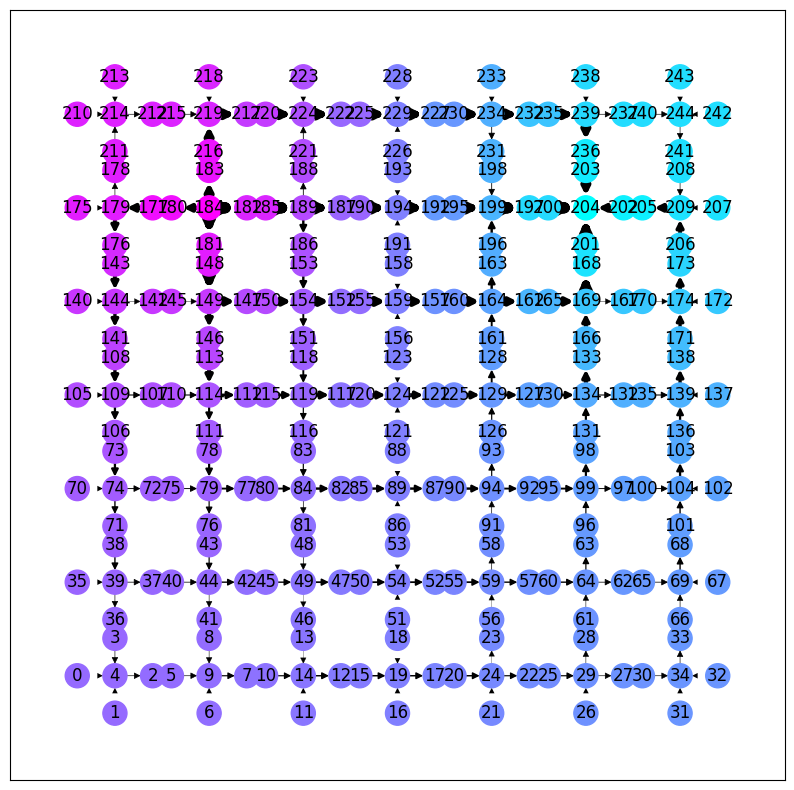

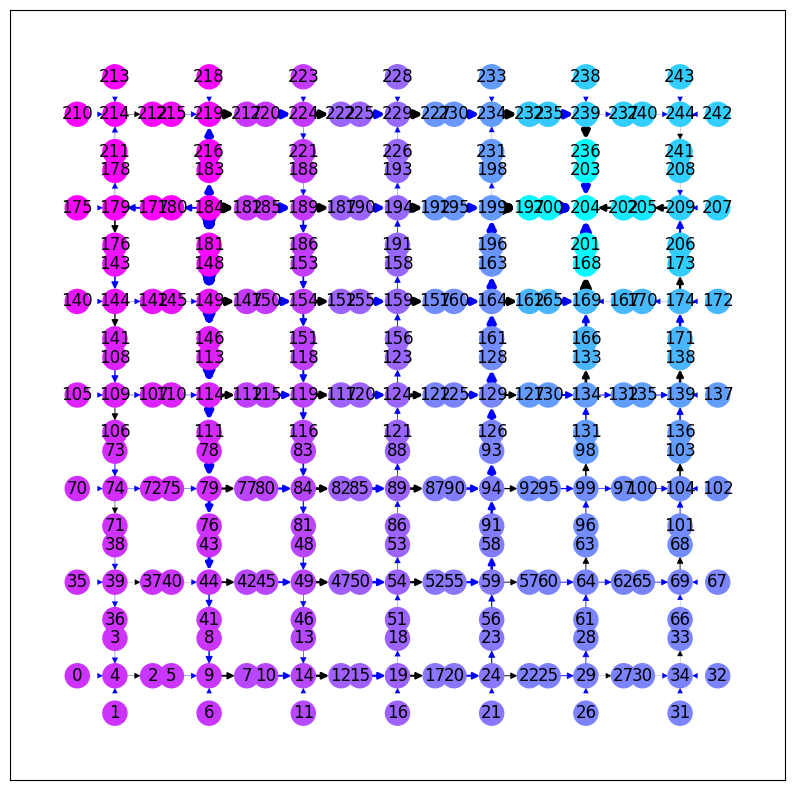

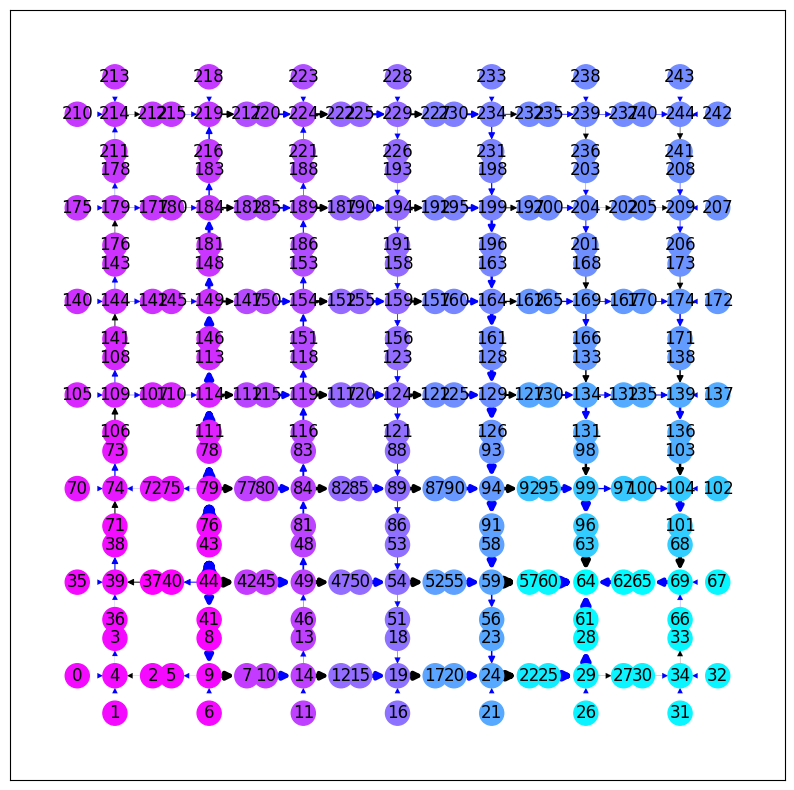

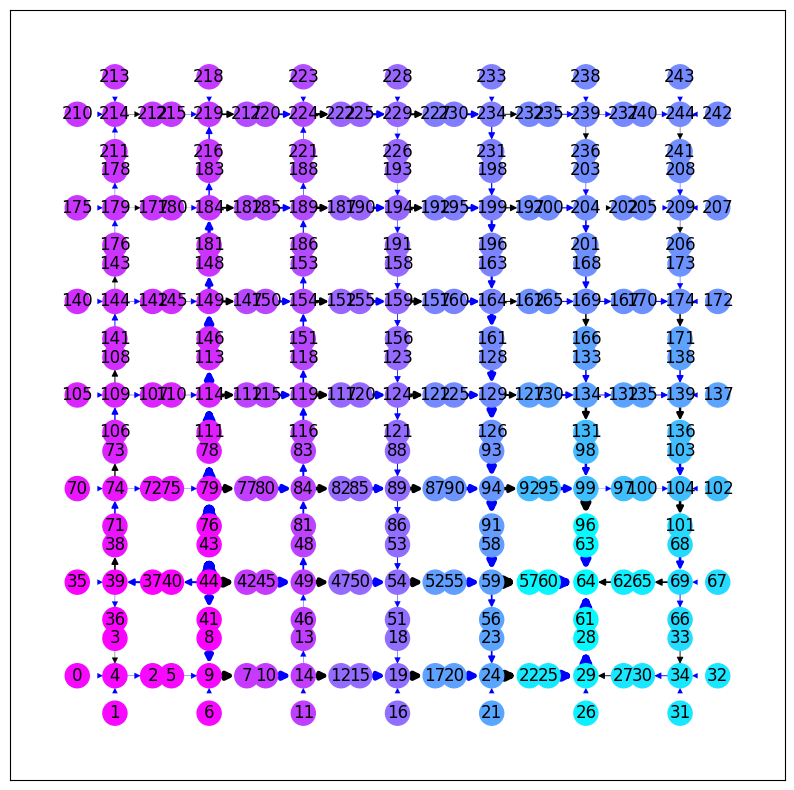

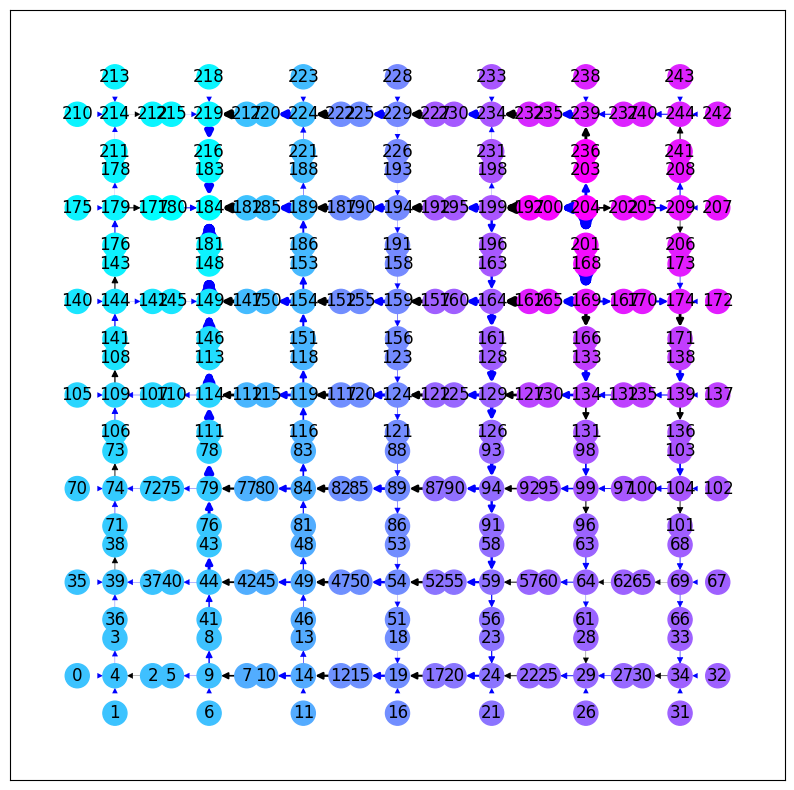

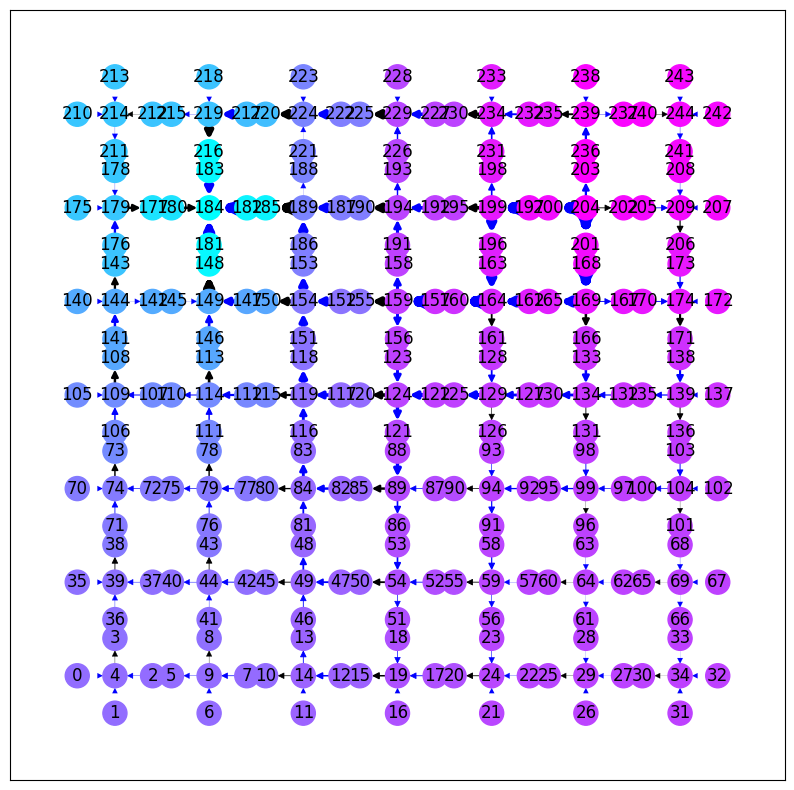

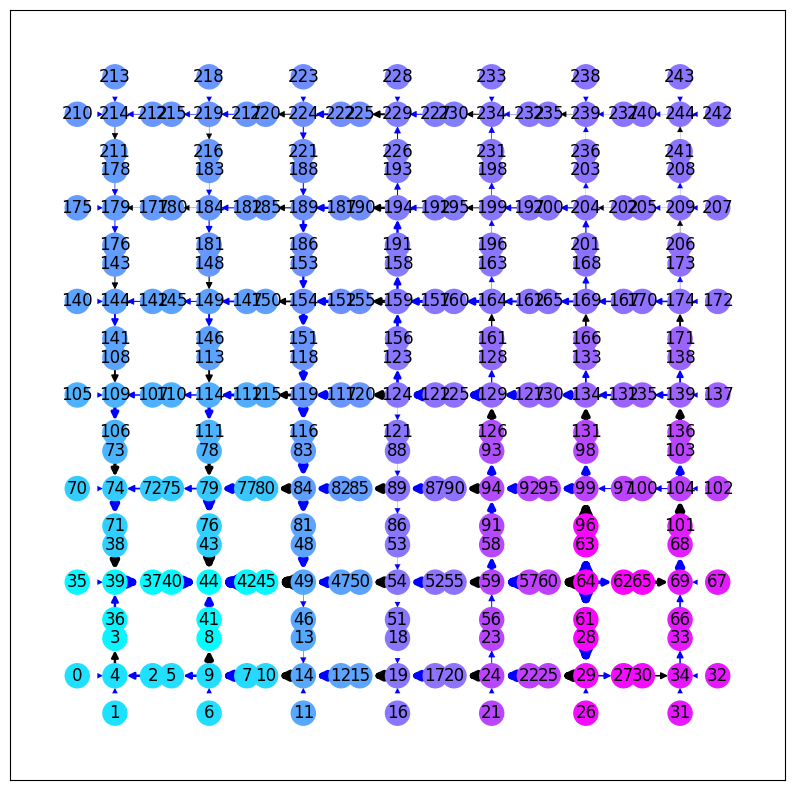

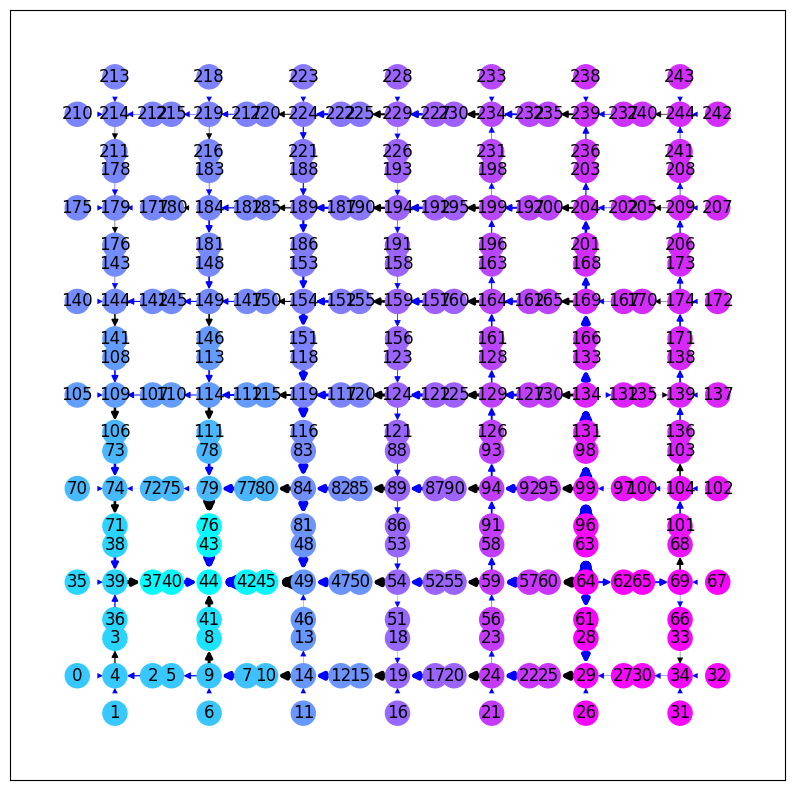

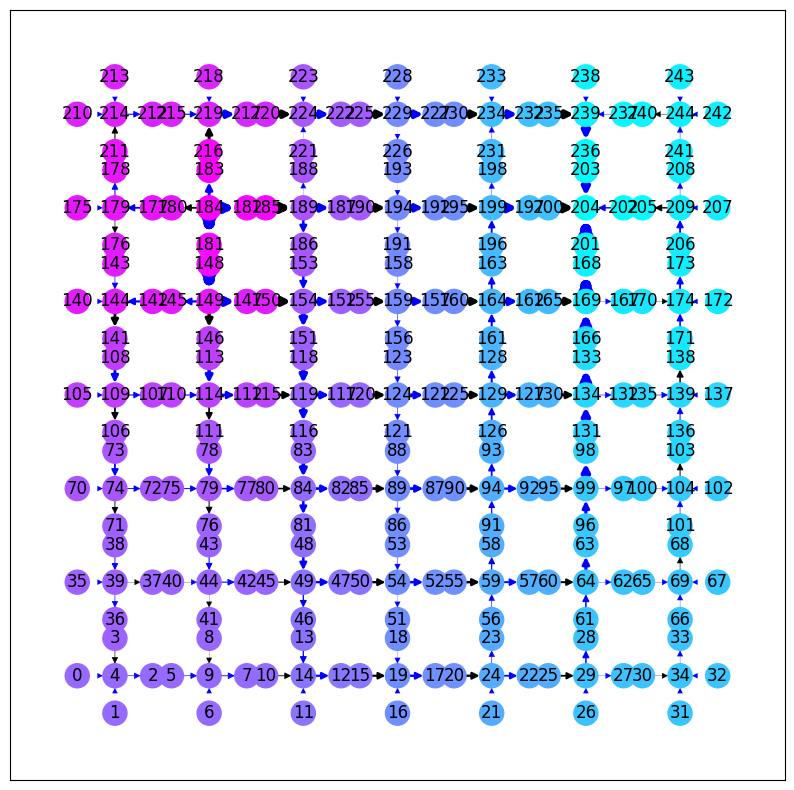

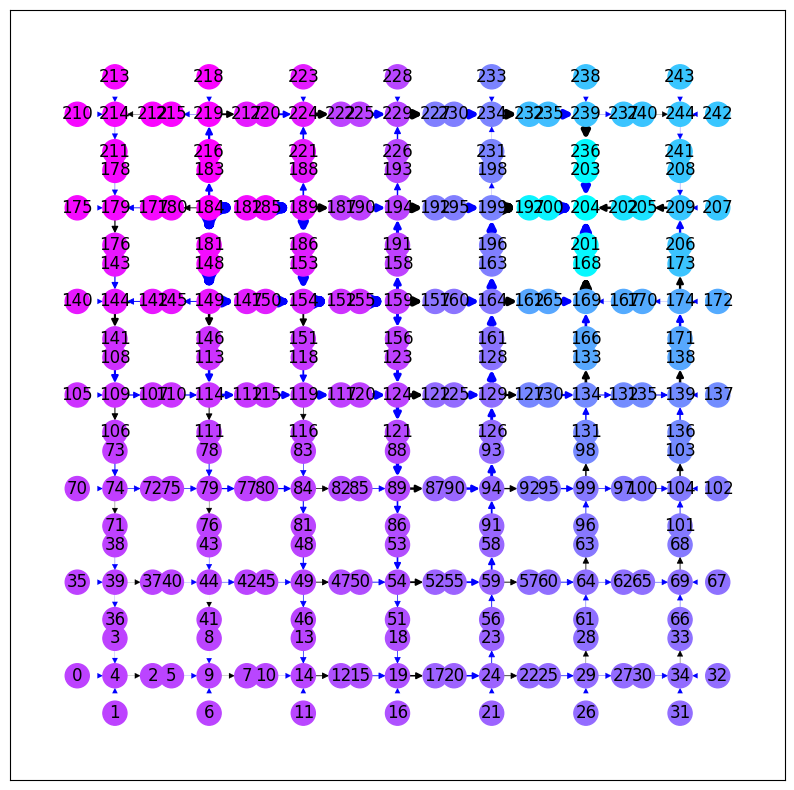

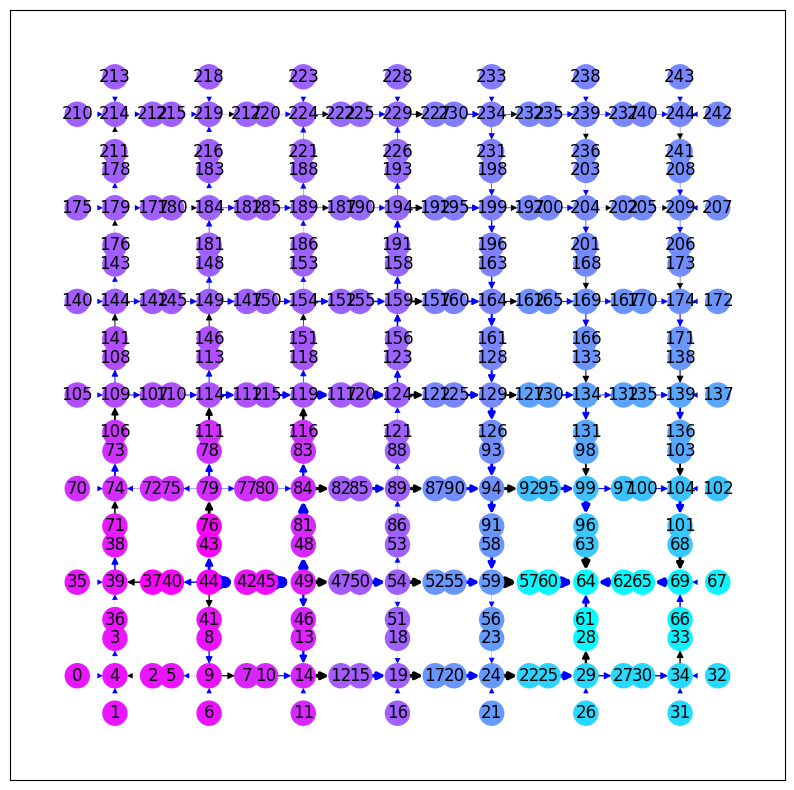

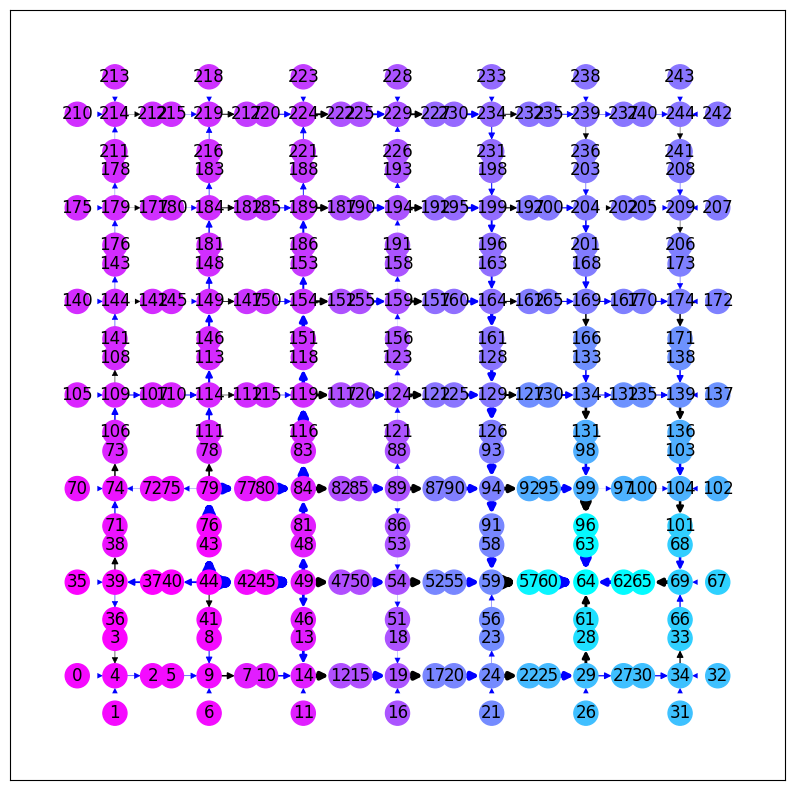

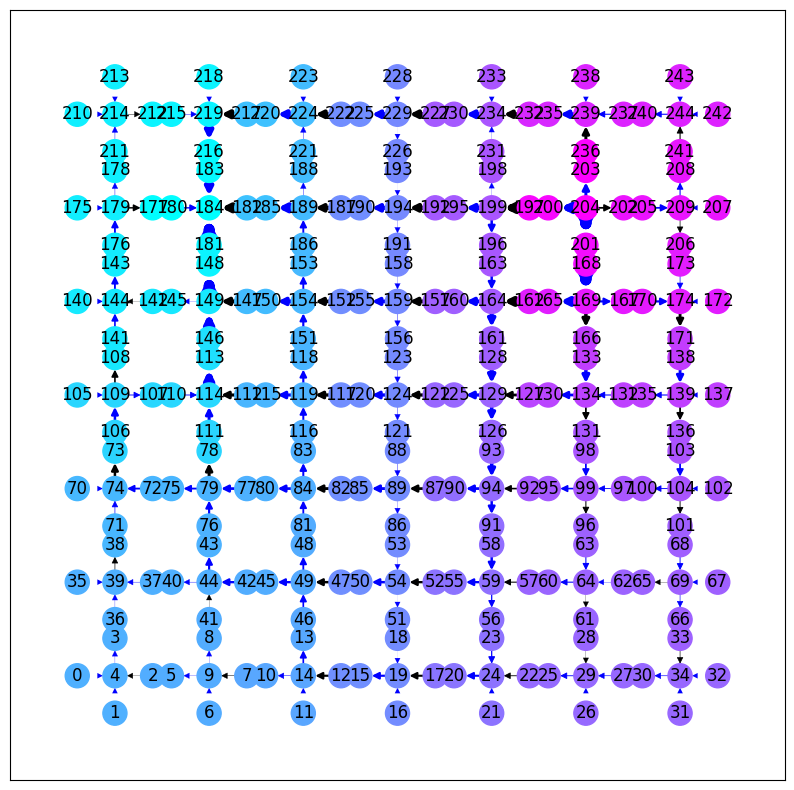

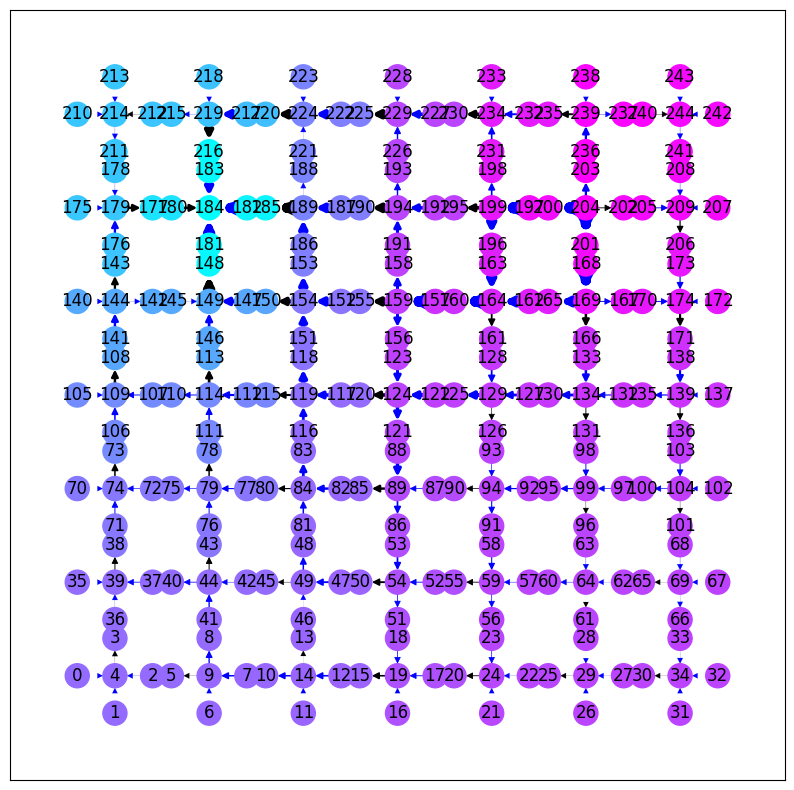

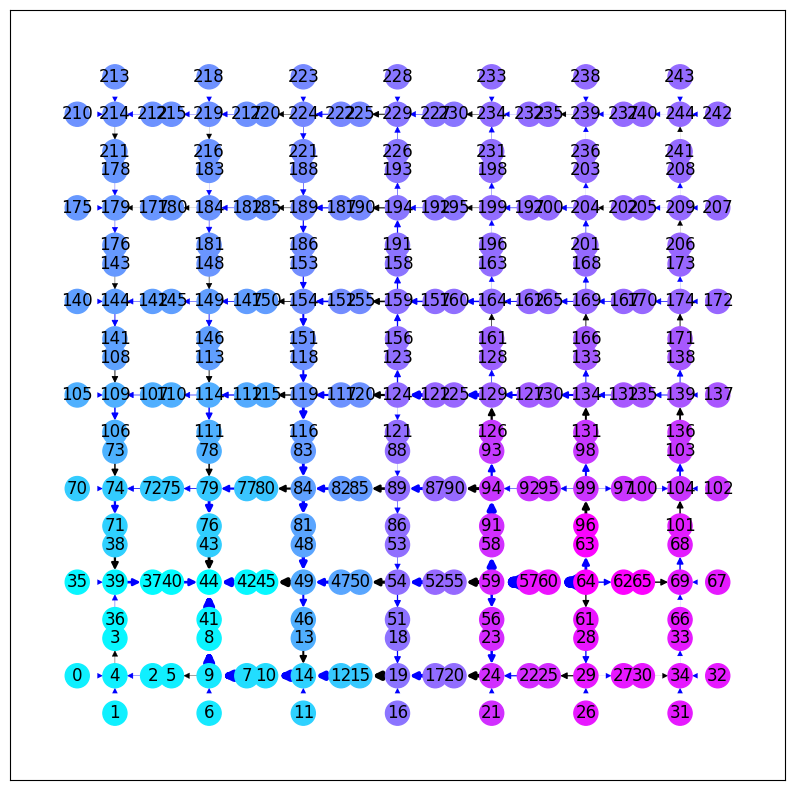

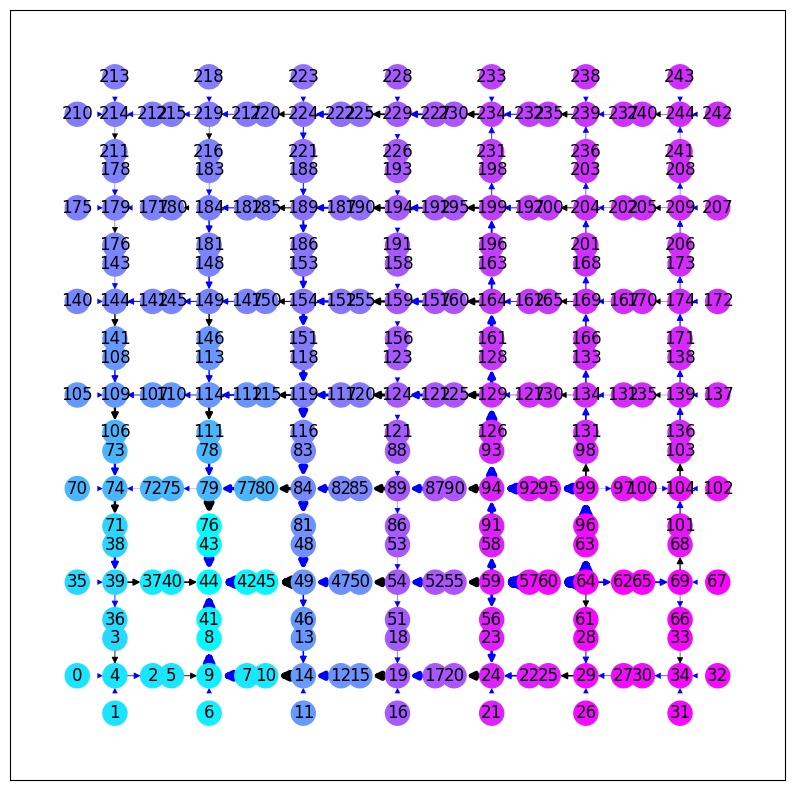

In [12]:
## Loop - Pose constraints, build constraints matrix, solve flow and update conductances until convergence,
##        change constraints and repeat

for i in range(8):
    m = i % 2
    
    # this is the normal direction of flow
    
    NodeData = NodeData_full[m] 
    Nodes = Nodes_full[m] 
    EdgeData = EdgeData_full[m]
    Edges = Edges_full[m]
    GroundNodes = GroundNodes_full[m]
    
    # switch ground and input nodes every 2nd iteration 
    if i % 4 > 1:
        Nodes = GroundNodes_full[m] 
        GroundNodes = Nodes_full[m]
    
    Cstr_full, Cstr, f = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  # As matrix
    
    for l in range(2):

        L, L_bar = Matrixfuncs.buildL(DM, K_mat, Cstr, NN)

        p, u = Solve.Solve_flow(L_bar, EI, EJ, K, f)
        
        # correct for very low velocities
        u[abs(u)<10**-10] = 0

        NETfuncs.PlotNetwork(p, u, K, NET, pos_lattice, EIEJ_plots, NN, NE)

        K_nxt = Matrixfuncs.ChangeKFromFlow(u, K, NGrid)
        K_mat = np.eye(NE) * K_nxt
        K = copy.copy(K_nxt)             

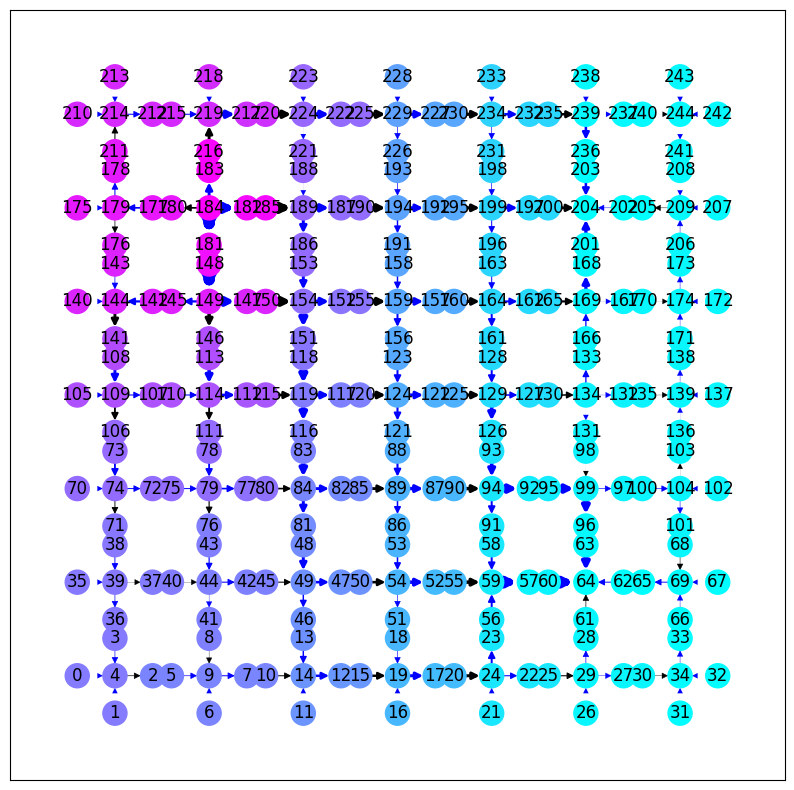

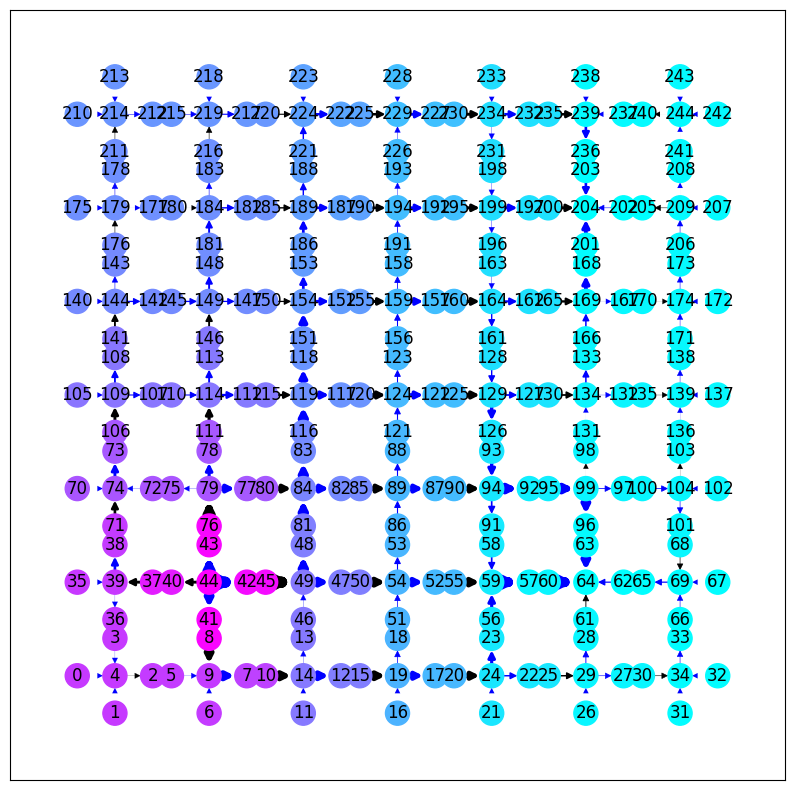

In [13]:
u_final_cond = zeros([2,2])

for i in range(2):
    NodeData = NodeData_full[i] 
    Nodes = Nodes_full[i] 
    EdgeData = EdgeData_full[i]
    Edges = Edges_full_Allostery[i]
    GroundNodes = GroundNodes_full_Allostery
    
    Cstr_full, Cstr, f = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  # As matrix

    L, L_bar = Matrixfuncs.buildL(DM, K_mat, Cstr, NN)

    p, u = Solve.Solve_flow(L_bar, EI, EJ, K, f)
    
    # correct for very low velocities
    u[abs(u)<10**-10] = 0


    NETfuncs.PlotNetwork(p, u, K, NET, pos_lattice, EIEJ_plots, NN, NE)

    # u_final_cond[i,:] = u[output_edges]
    u_final_cond[i,:] = [np.sum(u[output_edges[0]]), np.sum(u[output_edges[1]])]

In [14]:
print('poshing from ' + str(Nodes_full[0]) + ' out of edge ' + str(GroundNodes_full[0]) + ' flows ' + str(u_final_cond[0,0]))
print('and out of edge ' + str(GroundNodes_full[1]) + ' flows ' + str(u_final_cond[0,1]))
print('poshing from ' + str(Nodes_full[1]) + ' out of edge ' + str(GroundNodes_full[0]) + ' flows ' + str(u_final_cond[1,0]))
print('and out of edge ' + str(GroundNodes_full[1]) + ' flows ' + str(u_final_cond[1,1]))

poshing from [184] out of edge [204] flows 0.09847760210257103
and out of edge [64] flows 0.14384819088084386
poshing from [44] out of edge [204] flows 0.07675773079523307
and out of edge [64] flows 0.13485257481083351


In [15]:
u_final_norm = u_final_cond/u_final_noCond
print(u_final_norm)

for i in range(2):
    print('for node ' + str(Nodes_full[i][0]) + ' the lower velocity is at ' + 
          str(GroundNodes_full[np.where(u_final_norm[:,i] == min(u_final_norm[:,i]))[0][0]]))

[[0.1787325  0.36439298]
 [0.19444095 0.24475148]]
for node 184 the lower velocity is at [204]
for node 44 the lower velocity is at [64]


### Roie Very Simple Net

A net of a single cross 

<div>
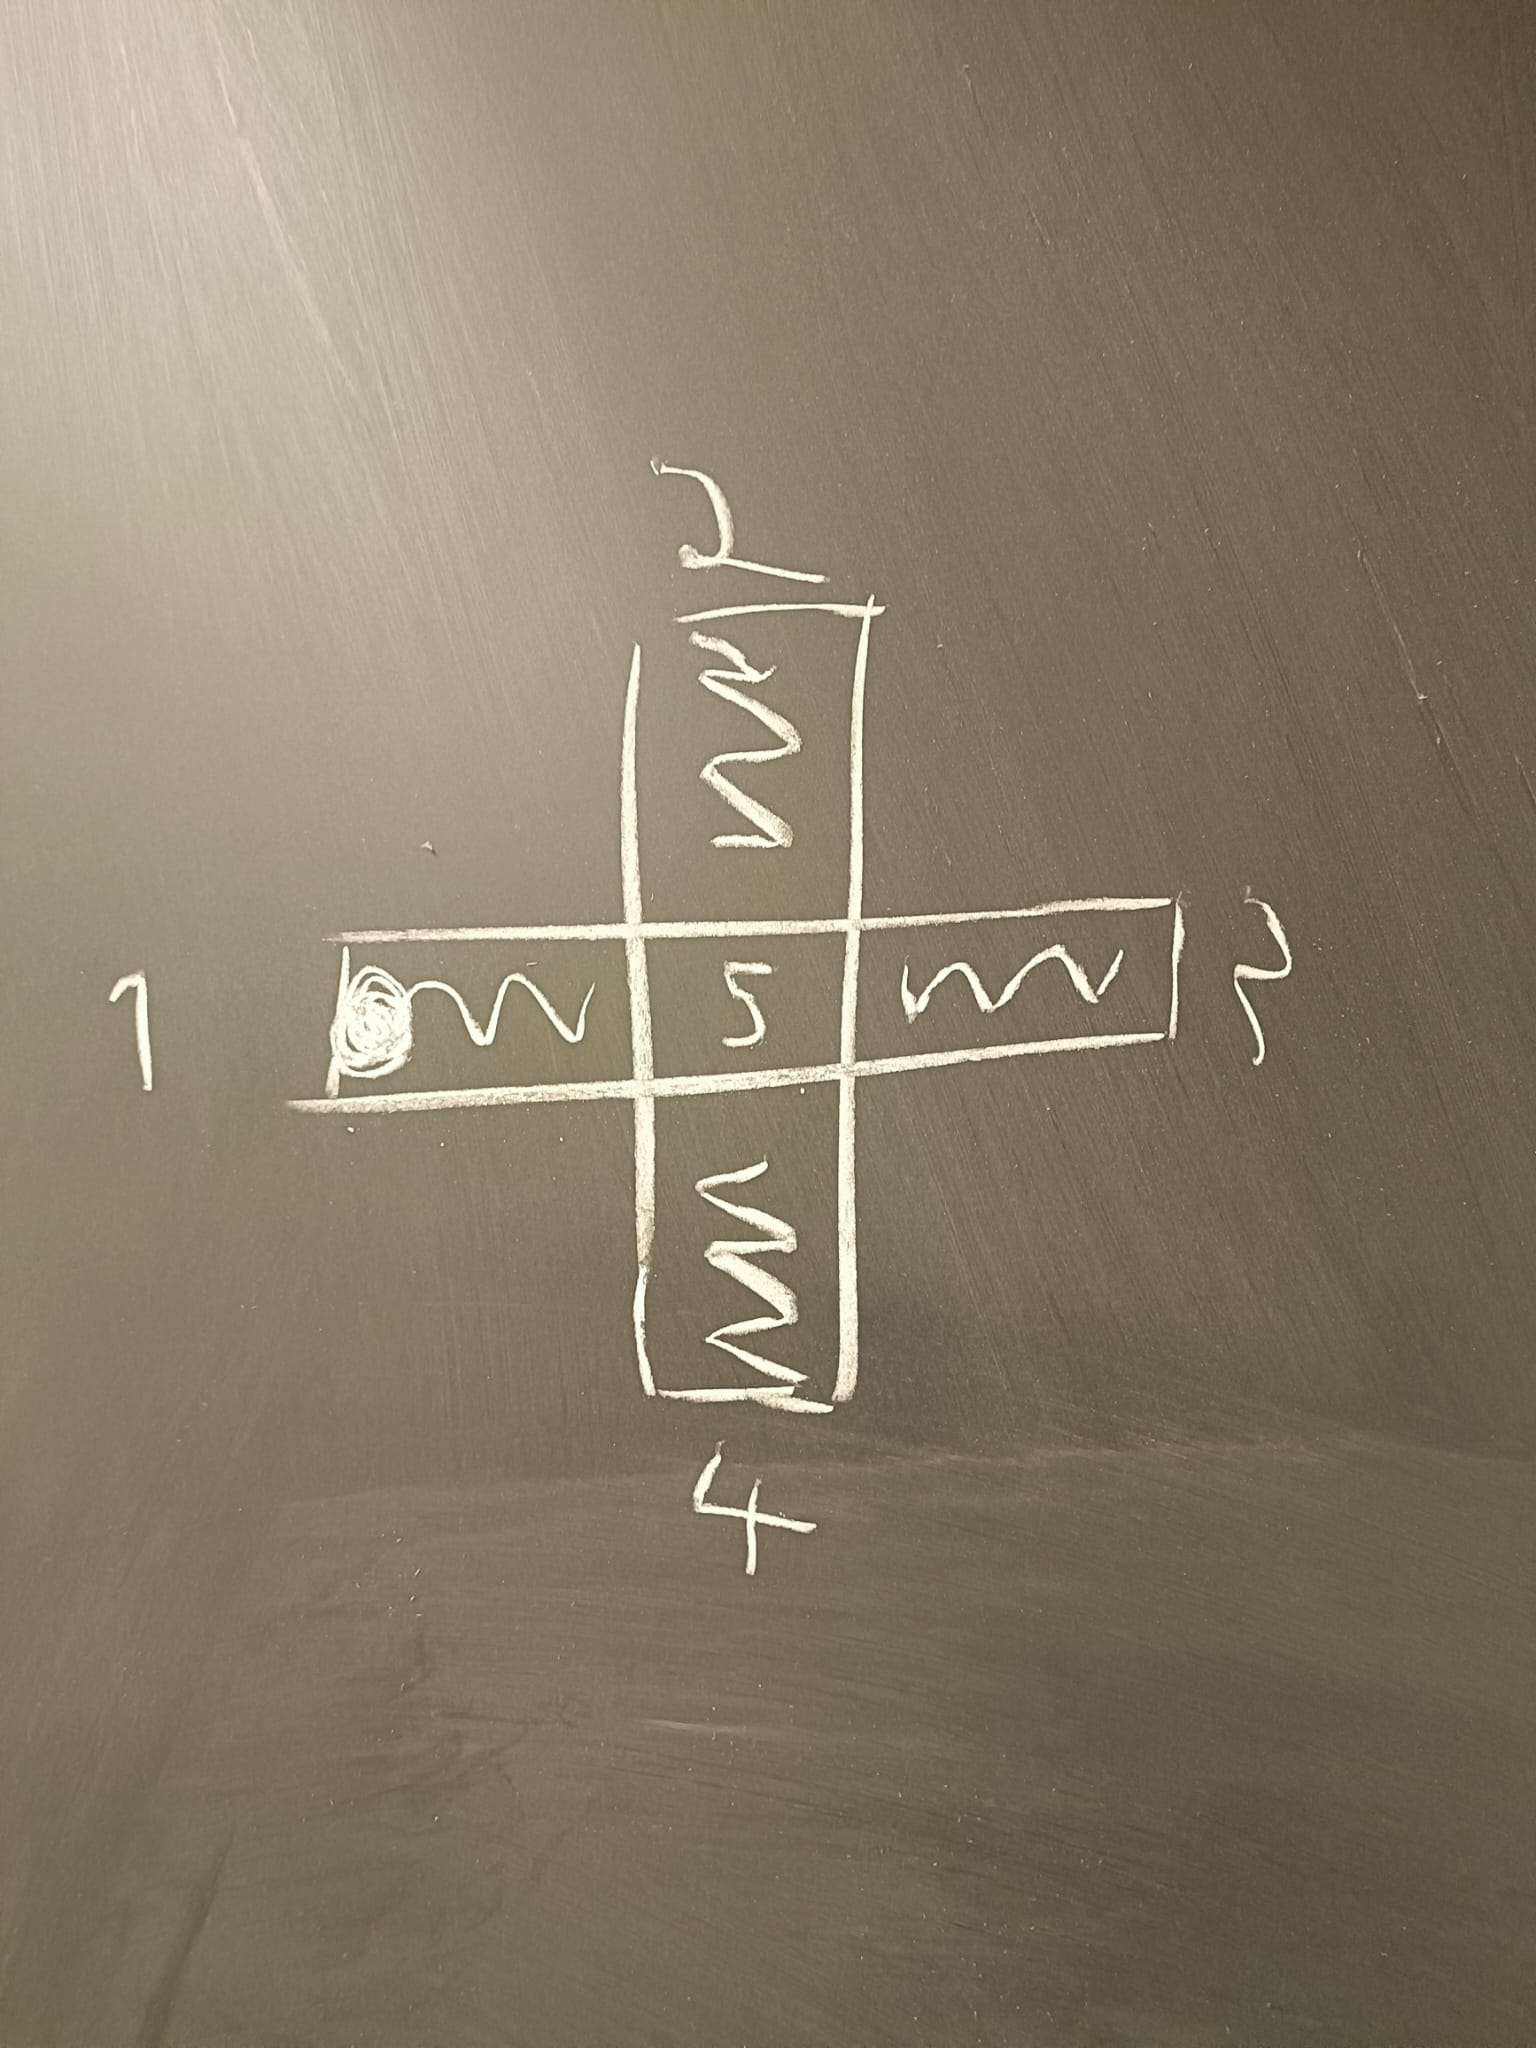
</div>

In [16]:
# NN = 5
# NE = 4
# EI = array([0, 1, 2, 3])
# EJ = array([4, 4, 4, 4])
# EIEJ_plots = [(str(EI[i]), str(EJ[i])) for i in range(len(EI))]
# NodeData = array([1])
# Nodes = array([0])
# # EdgeData = array([0, 0])
# # Edges = array([1, 3])
# # GroundNodes = array([2])
# EdgeData = array([0])
# Edges = array([1])
# GroundNodes = array([2, 3])

# DM = zeros([NE, NN])
# for i in range(NE):
#     DM[i,EI[i]] = +1.
#     DM[i,EJ[i]] = -1.

In [17]:
# ## Initiate K and constraints

# K = 2*ones([4])
# K[0] = 1
# K_mat = eye(NE) * K

# Cstr_full = Constrains.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)
# Cstr = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)[:,:-1]
# # Comp = ConstraintMatrix([], [], OutEdgesVals, OutEdges, [], NN, EI, EJ)[:,:-1]
# f = zeros([NN + len(Cstr), 1])
# # f[0,0] = 1
# f[NN:,0] = Cstr_full[:,-1]

In [18]:
# for i in range(4):
    
#     print(K)
    
#     L = dot(DM.T, dot(K_mat, DM))
#     L_bar = zeros([NN + len(Cstr), NN + len(Cstr)])
#     # LC = zeros([NN + len(Cstr) + len(Comp), NN + len(Cstr) + len(Comp)])
#     L_bar[NN:,:NN] = Cstr
#     L_bar[:NN,NN:] = Cstr.T
#     L_bar[:NN,:NN] = L
    
#     # Inverse Lagrangian
#     IL_bar = inv(L_bar)

#     p = dot(IL_bar,f)
#     u = ((p[EI] - p[EJ]).T*K)[0]
#     print(u)
    
#     K = Matrixfuncs.ChangeKFromFlow(u, K)
#     K_mat = eye(NE) * K

### Plot Very Simple Network

In [19]:
# G = nx.DiGraph()
# G.add_edges_from(EIEJ_plots)

# val_map = {str(i) : p[i][0] for i in range(NN)}
# pos_map = {'0' : array([-0.5, 0]),
#            '1' : array([0, 0.5]),
#            '2' : array([0.5, 0]),
#            '3' : array([0, -0.5]),
#            '4' : array([0, 0])}
# print(val_map)

# values = [val_map.get(node, 0.25) for node in G.nodes()]


# # Specify the edges you want here
# red_edges = [EIEJ_plots[int(where(K==min(K))[0])]]
# edge_colours = ['black' if not edge in red_edges else 'red'
#                 for edge in G.edges()]
# black_edges = [edge for edge in G.edges() if edge not in red_edges]

# # save arrow sizes
# rescaled_u = u*3/max(u)
# edgewidths_b = rescaled_u[where(K!=min(K))]
# print(edgewidths_b)
# edgewidths_r = rescaled_u[where(K==min(K))[0]]
# print(edgewidths_r)

# # Need to create a layout when doing
# # separate calls to draw nodes and edges
# # pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, pos_map, cmap=plt.get_cmap('cool'), 
#                        node_color = values, node_size = 500)
# nx.draw_networkx_labels(G, pos_map)
# nx.draw_networkx_edges(G, pos_map, edgelist=red_edges, edge_color='r', arrows=True, width=edgewidths_r)
# nx.draw_networkx_edges(G, pos_map, edgelist=black_edges, arrows=False, width=edgewidths_b)
# plt.show()

# print(G.edges)
# print(EIEJ_plots)

In [20]:
# # Net structure - edges and nodes

# # dim = 3
# # NET_prim = nx.grid_2d_graph(dim,dim)
# # NET_prim.remove_node((0, 0))
# # NET_prim.remove_node((0, dim-1))
# # NET_prim.remove_node((dim-1, 0))
# # NET_prim.remove_node((dim-1, dim-1))
# # # pos_lattice = {i : pos_lattice(i)}

# # NN = len(NET_prim.nodes)
# # NE = len(NET_prim.edges)
# # edges_2d_to_1d_dict = {str(e) : i for i, e in enumerate(NET_prim.nodes)}
# # edges_1d_to_2d_dict = {i : e for i, e in enumerate(NET_prim.nodes)}
# # EI = array([edges_2d_to_1d_dict[str(e[0])] for e in NET_prim.edges])
# # EJ = array([edges_2d_to_1d_dict[str(e[1])] for e in NET_prim.edges])
# # EIEJ_plots = [(str(EI[i]), str(EJ[i])) for i in range(len(EI))]

# # # EIEJ_plots = [(edges_1d_to_2d_dict[EI[i]], edges_1d_to_2d_dict[EJ[i]]) for i in range(len(EI))]
# # print(EIEJ_plots)

# # NET = nx.DiGraph()
# # for i, edge in enumerate(EIEJ_plots):
# #     NET.add_edge(edge[0], edge[1])
# # print(NET_prim.nodes)
# # print(NET.nodes)
# # print(NET_prim.edges)
# # print(NET.edges)

# DM = zeros([NE, NN])
# for i in range(NE):
#     DM[i,EI[i]] = +1.
#     DM[i,EJ[i]] = -1.

# # Plot net structure 

# # pos_lattice_prim = nx.spectral_layout(NET_prim)
# # nx.draw_networkx(NET_prim, pos_lattice_prim)
# # plt.show()

# # pos_lattice = nx.spring_layout(NET)
# pos_lattice = nx.spectral_layout(NET)
# nx.draw_networkx(NET, pos_lattice)
# plt.show()
    
# # Constraints 

# NodeData = array([1])
# Nodes = array([0])
# EdgeData = array([0])
# Edges = array([1])
# GroundNodes = array([NN-1])

# Cstr_full = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)  # As matrix
# # move last row to vector f
# Cstr = Constraints.ConstraintMatrix(NodeData, Nodes, EdgeData, Edges, GroundNodes, NN, EI, EJ)[:,:-1]  
# f = zeros([NN + len(Cstr), 1])  # as in Rocks and Katifori 2018 https://www.pnas.org/cgi/doi/10.1073/pnas.1806790116
# f[NN:,0] = Cstr_full[:,-1]

# ## Initiate K and constraints

# K = 2*ones([NE])
# K[0] = 1
# K_mat = eye(NE) * K

# ## Solve flow

# for i in range(2):
    
#     print(K)
    
#     L = dot(DM.T, dot(K_mat, DM))
#     L_bar = zeros([NN + len(Cstr), NN + len(Cstr)])
#     # LC = zeros([NN + len(Cstr) + len(Comp), NN + len(Cstr) + len(Comp)])
#     L_bar[NN:,:NN] = Cstr
#     L_bar[:NN,NN:] = Cstr.T
#     L_bar[:NN,:NN] = L
    
#     # Inverse Lagrangian
#     IL_bar = inv(L_bar)

#     p = dot(IL_bar,f)
#     u = ((p[EI] - p[EJ]).T*K)[0]
#     print(p)
#     print(u)
    
#     # K = Kfuncs.ChangeKFromFlow(u, K)
#     # K_mat = eye(NE) * K

# # nx.draw_networkx_nodes(NET, pos_map, cmap=plt.get_cmap('cool'), 
# #                        node_color = values, node_size = 500)
# # nx.draw_networkx_labels(G, pos_map)
# # nx.draw_networkx_edges(G, pos_map, edgelist=red_edges, edge_color='r', arrows=True, width=edgewidths_r)
# # nx.draw_networkx_edges(G, pos_map, edgelist=black_edges, arrows=False, width=edgewidths_b)
# # plt.show()

In [21]:
# val_map_prim = {edges_1d_to_2d_dict[i] : p[i][0] for i in range(NN)}
# val_map = {str(i) : p[i][0] for i in range(NN)}
# values_prim = [val_map_prim.get(node, 0.25) for node in NET_prim.nodes()]
# values = [val_map.get(node, 0.25) for node in NET.nodes()]
# # Specify the edges you want here
# red_edges = [EIEJ_plots[int(where(K==min(K))[0])]]
# print(red_edges)
# red_edges_prime = [edges_1d_to_2d_dict[EIEJ_plots[int(where(K==min(K))[0])]]]
# print(red_edges_prime)

# edge_colours_prim = ['black' if not edge in red_edges else 'red'
#                 for edge in NET_prim.edges()]
# edge_colours = ['black' if not edge in red_edges else 'red'
#                 for edge in NET.edges()]
# black_edges_prim = [edge for edge in NET_prim.edges() if edge not in red_edges]
# black_edges = [edge for edge in NET.edges() if edge not in red_edges]


# # save arrow sizes
# rescaled_u = u*3/max(u)
# edgewidths_b = rescaled_u[where(K!=min(K))]
# # print(edgewidths_b)
# edgewidths_r = rescaled_u[where(K==min(K))[0]]
# # print(edgewidth_r)

# # Need to create a layout when doing
# # separate calls to draw nodes and edges
# # pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(NET, pos_lattice, cmap=plt.get_cmap('cool'), 
#                        node_color = values, node_size = 500)
# nx.draw_networkx_labels(NET, pos_lattice)
# nx.draw_networkx_edges(NET, pos_lattice, edgelist=red_edges, edge_color='r', arrows=True, width=edgewidths_r)
# nx.draw_networkx_edges(NET, pos_lattice, edgelist=black_edges, arrows=False, width=edgewidths_b)
# plt.show()

# nx.draw_networkx_nodes(NET_prim, pos_lattice_prim, cmap=plt.get_cmap('cool'), 
#                        node_color = values, node_size = 500)
# nx.draw_networkx_labels(NET_prim, pos_lattice_prim)
# nx.draw_networkx_edges(NET_prim, pos_lattice_prim, edgelist=red_edges, edge_color='r', arrows=True, width=edgewidths_r)
# nx.draw_networkx_edges(NET_prim, pos_lattice_prim, edgelist=black_edges, arrows=False, width=edgewidths_b)
# plt.show()